** Under construction !!! **

## q<sup>2</sup> Tutorial - 6. Stellar parameters from isochrones

Fundamental stellar parameters like mass, age, luminosity, and radius are difficult to derive from basic principles. For many stars, however, theoretical isochrones can be used to constrain these parameters. The isopars module in q$^2$ contains a number of functions that may be employed for this purpose. Let's begin by importing q<sup>2</sup>:

In [1]:
import q2

and requesting an isochrone of given age (in Gyr) and [Fe/H]:

In [2]:
iso = q2.isopars.get_isochrone(age=4.5, feh=0)

The result is a dictionary containing the data for the isochrone requested. You can find out which columns are available and then print the first five rows of one of these columns (logg) as follows:

In [3]:
print iso.keys()
print iso['logg'][:5]

['logg', 'logt', 'mv', 'mass', 'logl']
[ 4.777   4.7769  4.7769  4.7767  4.7765]


With these isochrone data we can make a standard $T_\mathrm{eff}-\log\,g$ plot:

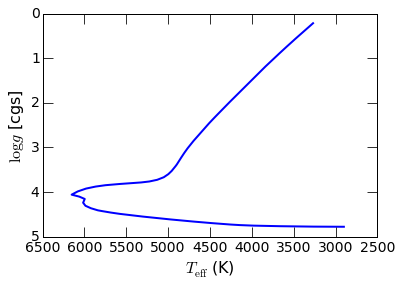

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(10**iso['logt'], iso['logg'])
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('$T_\mathrm{eff}$ (K)')
plt.ylabel('$\log g$ [cgs]')

By default, the isochrone grid employed is the Yonsei-Yale one ("yy"), spaced in [Fe/H] intervals of "0.02" dex. This grid is in an SQLite ("sql3") database called "yy02.sql3". To get the same isochrone, but from the finely-spaced grid version (0.01 dex steps in [Fe/H]), we use the yy01.sql3 database instead. We can also grab an isochrone from a finely-spaced Darmouth database (dm01.sql3) for comparison:

In [5]:
iso_yy = q2.isopars.get_isochrone(age=4.5, feh=0, db='yy01.sql3')
iso_dm = q2.isopars.get_isochrone(age=4.5, feh=0, db='dm01.sql3')

Now, let's compare them on the H-R diagram:

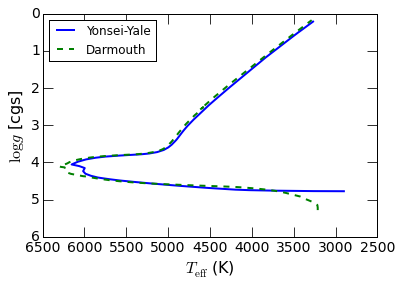

In [6]:
plt.plot(10**iso_yy['logt'], iso_yy['logg'], label='Yonsei-Yale')
plt.plot(10**iso_dm['logt'], iso_dm['logg'], '--', label='Darmouth')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('$T_\mathrm{eff}$ (K)')
plt.ylabel('$\log g$ [cgs]')

plt.legend(loc='best')

As stated above, it is possible to determine stellar parameters like mass and age by comparing the location of the stars in stellar parameter space with those of a given set of isochrones. The "location" of a star is of course never known with infinite precision. Thus, to derive isochrone parameters, a star object must have its stellar parameters *and* errors defined:

In [7]:
sun = q2.Star('Sun', teff=5777, logg=4.437, feh=0.0)
sun.err_teff = 5
sun.err_logg = 0.01
sun.err_feh = 0.005

The isopars.solve_one function takes a star object like the one defined above and performs a maximum-likelihood calculation to determine which mass, age, etc., values are the most probable ("m.p."). It also calculates 1-$\sigma$-like and 2-$\sigma$-like ranges for these parameters, as well as simple mean and standard deviation values of all isochrone points that fell inside the star's location box.

Before the calculation is made, SolvePars and PlotPars controllers must be defined. Use the former to specify the isochrone database to employ (Yonsei-Yale, 0.01 dex [Fe/H] spacing this case) and the 'key_parameter_known', which can be either the parallax ('plx', the default) or a 'logg' value, determined for example spectroscopically. In this case (Sun), we do not have a parallax available, so we will use the $\log\,g$ value instead:

In [30]:
sp = q2.isopars.SolvePars()
sp.db = 'yy01.sql3'
sp.key_parameter_known = 'logg'

q2.isopars.solve_one(sun, sp)

Using 114 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
----------   ------ | --------------- | --------------- | -----------------
age           4.100 |  3.704 -  4.712 |  3.283 -  5.200 |  4.204 +/-  0.490
mass          1.010 |  1.003 -  1.024 |  1.000 -  1.029 |  1.012 +/-  0.005
logl                |        -        |        -        |  0.003 +/-  0.009
mv            4.840 |  4.821 -  4.859 |  4.784 -  4.882 |  4.829 +/-  0.022
r             1.000 |  0.991 -  1.012 |  0.982 -  1.045 |  1.004 +/-  0.009


A figure showing the probability density distribution is generated:

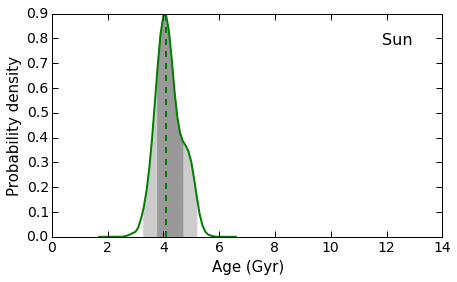

In [32]:
from IPython.display import Image
Image(filename='Sun_isoage_logg.png')

By default, the figure generated is in PNG format, but it could be changed to, for example JPG by using the figure_format attribute of PlotPars, as shown below. You can also set this parameter to EPS or PDF. In addition, we can change the limits of the x-axis in this figure, as well as the title inside of the box.

Note that the age derived is a bit young (the Sun's age is 4.6 Gyr), while the mass is 1% over the actual solar mass. This is an inevitable limitation of the isochrones. One way to address this problem is to shift the [Fe/H] values of the isochrones by a certain amount. For Yonsei-Yale isochrones, for example, an offset of -0.04 dex produces better solar age and mass values (but the absolute magnitude is now farther from the accepted value of 4.83):

Using 113 isochrone points

Parameter      m.p. |  1-sigma range  |  2-sigma range  |   mean +/-  stdev
----------   ------ | --------------- | --------------- | -----------------
age           4.600 |  4.134 -  5.108 |  3.581 -  5.510 |  4.627 +/-  0.481
mass          1.000 |  0.992 -  1.014 |  0.985 -  1.019 |  1.000 +/-  0.005
logl          0.010 | -0.007 -  0.024 | -0.019 -  0.029 | -0.001 +/-  0.009
mv            4.850 |  4.822 -  4.874 |  4.806 -  4.924 |  4.835 +/-  0.018
r             1.000 |  0.990 -  1.012 |  0.980 -  1.028 |  1.000 +/-  0.010


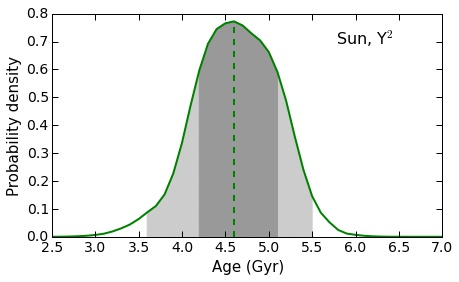

In [39]:
pp.figure_format = 'jpg'
pp.age_xlim = [2.5, 7]
pp.title_inside = 'Sun, Y$^2$'

sp.feh_offset = -0.04
q2.isopars.solve_one(sun, sp, pp)

Image(filename='Sun_isoage_logg.jpg')

USING PARALLAX:

SAMPLE OF STARS:

COMPARISON TO [ISOCHRONES](http://isochrones.readthedocs.org/en/latest/)